In [1]:
pip install -r ../requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install job-offer-classifier --upgrade > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# default 

In [5]:
from os import path,listdir
from shutil import rmtree
import pandas as pd
import numpy as np
import job_offer_classifier
from job_offer_classifier.pipeline_classifier import Pipeline
from job_offer_classifier.validations import KFoldPipe
from job_offer_classifier.pipeline_classifier import plot_confusion_matrix

In [6]:
job_offer_classifier.__version__

'0.0.5'

In [7]:
# Shutdown TF info logging
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Balance the dataset

Cibatel+webpage

In [8]:
df = pd.read_csv('../data/raw/training_payloads.csv')
nb_cases = min([min(df.sentiment.value_counts().values),50])
df_pos = df[df.sentiment == 1].sample(nb_cases)
df_neg = df[df.sentiment == 0].sample(nb_cases)

df_balanced = pd.concat([df_pos,df_neg]).sample(frac = 1)

mocks

In [9]:
df_mocks_pos_neg = pd.read_csv('../data/interim/mocks_pos_neg.csv')

All

In [10]:
df = pd.concat([df_balanced,df_mocks_pos_neg.drop('mocker',axis=1)])
df.to_csv('../data.csv')

In [11]:
df.sentiment.value_counts()

0    97
1    75
Name: sentiment, dtype: int64

In [12]:
kfp = KFoldPipe(n_splits = 4,src_file='../data.csv')
kfp.train_steps = 600

In [13]:
kfp.k_fold_validation()

In [14]:
kfp.best_seed

2889020638

In [15]:
kfp.random_state = kfp.best_seed
kfp.pipeline()

In [16]:
path.isdir('/models')

True

In [17]:
rmtree('/models/all_estimator',ignore_errors=True)
kfp.export_estimator('/models/all_estimator')

In [ ]:
#

In [ ]:
#del kfp

In [19]:
kfp = KFoldPipe(n_splits =1,src_file='../data.csv',estimator_dir='/models/all_estimator')
kfp.load_estimator()
kfp.input_fns()

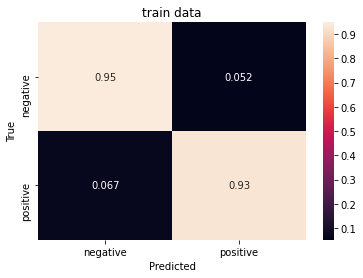

In [20]:
kfp.plot_confusion_matrix('train')

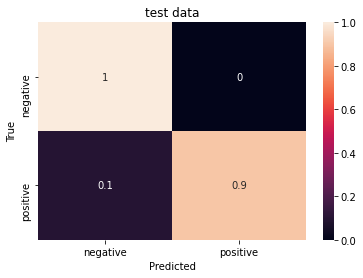

In [21]:
kfp.plot_confusion_matrix('test')

In [ ]:
df_ex =  kfp.dfs['test'].sample(5)
df_ex['prediction'] = kfp.predict(df_ex)

for k,r in df_ex.iterrows():
    print(k,sep='\n')
    print(r.payload.strip(), f'Expected: {r.sentiment}',f'Predicted: {r.prediction}',sep='\n')
 

The dataset consists of mock emails by the Intekglobal employees. 

Convert 'positive' and 'negative' values to 1 and 0 values, respectively.